In [1]:
# Nonlinear dynamics JC
# n bit flip flop task example
# (note Jacobian and eigen decomposition part is not implemented yet!)
# AK, July-4-2022
# =========================================================================
%reset -f
# %matplotlib notebook
import os, sys
from pathlib import Path
from pprint import pprint

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))
DIR_LIB = os.path.join(str(Path.home()), 'Dropbox', 'w_LABWORKS', 'STUDYGROUPS', 'DeepLearningFromScratch', 'PyTorch_library')
sys.path.append(DIR_LIB)

# Basic
import numpy as np
import pandas as pd
from numpy import linalg as ln
import matplotlib.pyplot as plt
# from ipywidgets import *

# Scipy & sklearn
import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize
from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchinfo import summary
from torchvision import datasets, transforms
import einops 

# PCA and Jax 
from sklearn.decomposition import PCA
from jax import jacfwd, jacrev
import jax.numpy as jnp

# PyTorch related functions 
from PyTorch_data import D_nbit_flipflop
from PyTorch_utils import L_default_weights, Trainer 

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

%who

Device used: cpu
DIR_HERE	 DIR_LIB	 D_nbit_flipflop	 F	 L_default_weights	 PCA	 Path	 Trainer	 Variable	 
datasets	 device	 einops	 integrate	 jacfwd	 jacrev	 jnp	 ln	 nn	 
np	 optim	 optimize	 os	 pd	 plt	 pprint	 scipy	 summary	 
sys	 torch	 transforms	 


In [3]:
?D_nbit_flipflop

Init signature: D_nbit_flipflop(seed=612, max_sample=1, n_time=500, n_rest=50, n_bit=3)
Docstring:     
n bit flip flop task (flat)
Maintain n bit of 3 bit of -1 or +1 state
n_time = how many time samples to make
n_rest = fixed time in-between flips
n_bit = number of bits
(x) = generated dataset
(t) = n bits of correct states
File:           ~/Dropbox/w_LABWORKS/STUDYGROUPS/DeepLearningFromScratch/PyTorch_library/PyTorch_data.py
Type:           type
Subclasses:     


In [2]:
#------------------------------
# Simulate data
n_batch = 350          # size of batch to train model
n_time = 100            # n arbitrary time steps
n_rest = 5
n_bit = 2              # range of frequency value (from 1)
data = D_nbit_flipflop(n_time = n_time, n_bit = n_bit, n_rest = n_rest, max_sample = n_batch)

# Data loader for training
train_dataloader = torch.utils.data.DataLoader(data,
                                            batch_size = n_batch,
                                            shuffle = True)
 
# Checking loader
for i, (inputs, labels) in (enumerate(train_dataloader)):print("done")
# plt.plot(labels[100])

done


In [3]:
#------------------------------
# Define hyperparameters
n_epochs = 4000         # how many times to repeat learning epochs
learning_rate = .002    # learning rate of the oprimizer
weight_decay  = .0001   # weight decay

# Layer properties
n_input = n_bit         # n_bit memory states
n_output = n_bit        # n_bit memory states
n_rnn_layers = 1        # number of rnn layers stacked
n_units_hidden = 64     # number of hidden units
rnn_nl = 'relu'         # nonlinear update function of rnn layer


#------------------------------
# Define neural network model (dense feedforward network)
class Net(nn.Module):
    def __init__(self, n_time, n_input, n_output, n_units_hidden, n_rnn_layers, rnn_nl):
        # Initialize module
        super(Net, self).__init__()
        self.n_time = n_time
        self.n_input = n_input
        self.n_output = n_output
        self.n_units_hidden = n_units_hidden
        self.n_rnn_layers = n_rnn_layers
        
        # Prepare layers
        self.rnn = nn.RNN(n_input, n_units_hidden, nonlinearity = rnn_nl, dropout = 0.0, batch_first = True) # regular RNN
        #self.rnn = nn.GRU(n_input, n_units_hidden, dropout = 0.0, batch_first = True) # gated recurrent unit
        self.fc = nn.Linear(n_units_hidden, n_output)
        
        # Initialize weights (to use defalt comment out all)
        #self.apply(self._init_weights)
        #self.apply(L_default_weights) # from PyTorch_util
        
    def _init_weights(self, m):
        print("To modify initial weights modify this part")
        raise NotImplementedError()
        
    def _set_state(self):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.n_rnn_layers, self.n_batch, self.n_units_hidden).zero_())
        
    def forward(self, x):  
        # Initialize hidden state
        self.n_batch = x.shape[0] # batch_first = True
        self.h_state = self._set_state()
        
        # Transform data: (Batch, Time, Input)
        x = x.view(self.n_batch, self.n_time, self.n_input)
        
        # Connect layers and pass on to activation functions
        #(rnn_out) = (batch, time, hidden_size)
        #(h_n) =  (num_layers, batch, hidden_size)
        h_all, h_n = self.rnn(x, self.h_state) # loop over n_time inside of rnn module
        
        # Hidden state at each time point is passed on to same output layer
        output = self.fc(h_all) 

        return output, h_all , h_n

#------------------------------
# Instantiate model
model = Net(n_time, n_input, n_output, n_units_hidden, n_rnn_layers, rnn_nl).to(device)
print(model)
summary(model, verbose = 2)

#------------------------------
# Define loss function
# CrossEntropyLoss = softmax + cross entropy error
criterion =  torch.nn.MSELoss()

#------------------------------
# Define optimier
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)



Net(
  (rnn): RNN(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Layer (type:depth-idx)                   Param #
Net                                      --
├─RNN: 1-1                               4,352
│    └─weight_ih_l0                      ├─128
│    └─weight_hh_l0                      ├─4,096
│    └─bias_ih_l0                        ├─64
│    └─bias_hh_l0                        └─64
├─Linear: 1-2                            130
│    └─weight                            ├─128
│    └─bias                              └─2
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0


In [574]:
#------------------------------
# Do training (make sure to get new model, criterion, optimizer)
model.train()  # change model as "training mode"

# Loop over n_epoch times
for epoch in range(n_epochs): 
    loss_sum = 0
    acc_sum = 0

    for inputs, targets in train_dataloader:        
        # CPU/GPU stuff (don't worry)
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        
        # Initialize gradient of optimizer
        optimizer.zero_grad()

        # Forward path
        outputs, h_all, h_n = model(inputs)
        
        # Calculate loss: difference between output and label
        loss = criterion(outputs, targets)
        
        # Backward path (Backpropagation!)
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Keep track of the progress of learning
        loss_sum += loss
        acc_sum += torch.sum(torch.abs(targets - outputs))

    # Display learning progress
    if  epoch % 200 == 0:
        epoch_loss = loss_sum.item() / len(train_dataloader) # cumulative loss/ batch size
        epoch_acc = acc_sum.double() / len(train_dataloader.dataset) # cummlative count of correct prediction / data size
        print(f"Epoch: {epoch+1}/{n_epochs}, Loss: {epoch_loss}, Acc: {epoch_acc}")

print('--Done!---\n')

Epoch: 1/8000, Loss: 0.9602431654930115, Acc: 192.85895089285714
Epoch: 201/8000, Loss: 0.11226889491081238, Acc: 59.10583705357143
Epoch: 401/8000, Loss: 0.025124624371528625, Acc: 22.9698046875
Epoch: 601/8000, Loss: 0.00141618843190372, Acc: 4.4348747907366075
Epoch: 801/8000, Loss: 0.0004949491703882813, Acc: 2.71518798828125
Epoch: 1001/8000, Loss: 0.00020273045811336488, Acc: 1.727449951171875
Epoch: 1201/8000, Loss: 0.00012182141654193401, Acc: 1.4525087193080357
Epoch: 1401/8000, Loss: 7.000821642577648e-05, Acc: 1.0530344935825893
Epoch: 1601/8000, Loss: 0.00010899109474848956, Acc: 1.4851827566964286
Epoch: 1801/8000, Loss: 0.0034152998123317957, Acc: 7.721667131696429
Epoch: 2001/8000, Loss: 0.0001566795981489122, Acc: 1.687640380859375
Epoch: 2201/8000, Loss: 6.839686102466658e-05, Acc: 1.1032754952566963
Epoch: 2401/8000, Loss: 4.743339741253294e-05, Acc: 0.8945219203404018
Epoch: 2601/8000, Loss: 3.6960260331397876e-05, Acc: 0.7965948486328125
Epoch: 2801/8000, Loss: 3.12

In [5]:
#------------------------------
# Save weight parameters
# torch.save(model.state_dict(), 'n_bit_flipflop_model_weights.pth')

# # Loading pre-trained data
model_path = 'n_bit_flipflop_model_weights.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [6]:
#------------------------------
# class LA_fixedpoints

class LA_fixedpoints:
    def __init__(self, model, device, layerN = 'rnn', q_tor = 1e-05, iter_noise = .1, iter_fp = 10000, lr_fp = .1, lr_decay_epoch = 1500):
        # model
        self.model = model
        self.device = device
        self.layerN = 'rnn'
        
        # q functions
        self.q_tor = q_tor # uppper max q to define fp
        self.qf = lambda Fx: (.5 * torch.norm(Fx) ** 2) # first term of linearlization
        #self.qf = lambda Fx: (torch.norm(Fx))
        
        # optimization
        self.iter_fp = iter_fp
        self.iter_noise = iter_noise
        self.lr_fp = lr_fp
        self.lr_decay_epoch = lr_decay_epoch
        
    def detect_fixedpoints(self, h_init, inputs, ic):
        # Initialize
        fixed_points = {'trajectories':[],'fp':[] ,'epoch':[], 'converge':[]}
        
        for i in range(ic):
            # Initialize network to one of the trajectories + noise
            # assume 2nd dimension of h_init (list of hidden states) is time
            e, fpF, converge, lr_fp = 0, True, True, self.lr_fp

            # Make Pytorch variable to use autograd 
            h_idx = torch.randint(h_init.shape[1], (1,))
            h_local = h_init[:, h_idx, :].detach().clone()
            h_local = h_local + (self.iter_noise ** .5) * torch.randn(h_local.shape)
            
            # Totally random place?
            # h_local = torch.randn(h_local.shape)

            # Gradient decent
            while True:
                # Reinstantiate
                h_local = Variable(h_local).to(self.device)
                h_local.requires_grad = True
                h_local.retain_grad()
                
                # Compute gradient 
                q = self.compute_qF(h_local, inputs)
                q.backward()            

                # Check convergence status
                if e % 2000 == 0: print(f'epoch: {e}, q={q.item()}')
                if e == self.iter_fp: converge = False
                if q.item() < self.q_tor or e == self.iter_fp:break

                # Update h_n 
                if e % self.lr_decay_epoch == 0 and e > 0: lr_fp *= 0.5
                h_local = h_local - lr_fp * h_local.grad
                e += 1
            
            # Evaluate all detected fixed points based on distance to
            # previously detected fixed points (first one is retained)
            if i > 0: fpF = self.eval_fixedpoints(e, fixed_points, h_local)
            if fpF:
                fixed_points['trajectories'].append(torch.squeeze(h_init))
                fixed_points['fp'].append(h_local)
                fixed_points['epoch'].append(e)
                fixed_points['converge'].append(converge)
            
        return fixed_points
    
    def compute_qF(self, h_local, inputs):        
        _, h_target = getattr(self.model, self.layerN)(inputs, h_local)        
        q = self.qf(h_target - h_local) # difference between most updated h_l and h_t   
        return q
    
    def eval_fixedpoints(self, e, fixed_points, h_local, dist_th = .1):
        d = [torch.cdist(f, h_local) for _,f in enumerate(fixed_points['fp'])]
        return torch.all(torch.cat(d) > dist_th)
        

    def compute_jacobian(self, h_fp, inputs):
        # Not implemented yet! 
        # To do:
        # - calculate Jacobian:from torch.autograd.functional import jacobian, hessian ??
        # - do eigen decompositions
        return None


In [24]:
#------------------------------
# Fixed point analysis (all memory states)

# Put the model evaluation mode
model.eval()
results = []

# Get all memory states 
states = [-1, 1]
states = np.array(np.meshgrid(*[states]*n_bit)).T.reshape(-1, n_bit)
print("Input conditions:")
print(states)

# # # Get all memory states & any starting states
# states = [-1, 0, 1]
# states = np.array(np.meshgrid(*[states]*n_bit)).T.reshape(-1, n_bit)
# states = np.unique(states, axis = 1)
# print(states)

# Loop over all conditions
for c, cc in enumerate(states):
    # Generate static inputs
    print('Working on memory state:', cc)
    inputs = torch.tensor(cc).repeat(n_time, 1)
    inputs = einops.rearrange(inputs, 't c -> 1 t c', c = n_output) 
    inputs = inputs.to(device).float()
    
    # Add random noise to inputs?
    inputs =  inputs + (.05 ** .5) * torch.randn(inputs.shape)

    # Get hidden states of the model (batch = 1, time, hidden units)
    with torch.no_grad(): _, h_all_t, _ = model(inputs)
    
    # Call a class to analyze fixed points
    # - q_tor = how small q should be to be defined as fixed points
    # - lr_fp = learning rate of q function optimizer
    # - iter_noise = noise added to initial hidden state (initial hidden state is randomly picked by "h_idx")
    fp_analyzer = LA_fixedpoints(model = model, device = device, lr_fp = .1, iter_fp = 20000, q_tor = 1e-08, iter_noise = .2)
    fixed_points = fp_analyzer.detect_fixedpoints(h_all_t, inputs, ic = 10)

    # Store results
    results.append(fixed_points)
    
print('--Done!--')

Input conditions:
[[-1 -1]
 [-1  1]
 [ 1 -1]
 [ 1  1]]
Working on memory state: [-1 -1]
epoch: 0, q=5.55226469039917
epoch: 0, q=8.26285171508789
epoch: 0, q=7.491600036621094
epoch: 0, q=9.229203224182129
epoch: 0, q=5.354135036468506
epoch: 0, q=5.6057281494140625
epoch: 0, q=5.4228596687316895
epoch: 0, q=5.881440162658691
epoch: 0, q=6.518489837646484
epoch: 0, q=5.766788959503174
Working on memory state: [-1  1]
epoch: 0, q=7.485531330108643
epoch: 0, q=7.459596633911133
epoch: 0, q=5.817906856536865
epoch: 0, q=8.564213752746582
epoch: 0, q=7.619823455810547
epoch: 0, q=5.811188220977783
epoch: 0, q=7.336668014526367
epoch: 0, q=8.350595474243164
epoch: 0, q=7.381692886352539
epoch: 0, q=7.575657367706299
Working on memory state: [ 1 -1]
epoch: 0, q=8.054780960083008
epoch: 0, q=7.210049152374268
epoch: 0, q=6.012560844421387
epoch: 0, q=4.2228498458862305
epoch: 0, q=5.919370174407959
epoch: 0, q=5.795217514038086
epoch: 0, q=6.603372573852539
epoch: 0, q=6.295004367828369
epoch

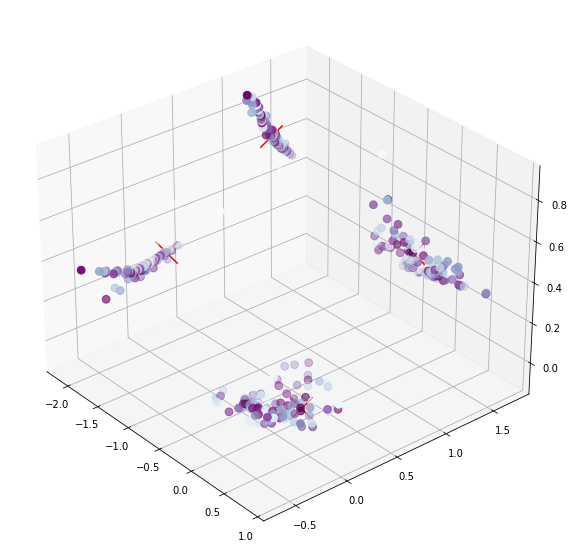

In [31]:
# -----------------
# PCA
m = results[0]['trajectories'][0]# use first condition as reference
pca = PCA()
pca.fit(m)

# Plot
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Loop over all conditions 
for e, i in enumerate(results):
    # PC dimensions
    pc_d = [0, 1, 2]
    
    # Plot trajectories
    tj = sum(i['trajectories']).detach().numpy()
    pc_tj = pca.transform(tj)
    #ax.plot(pc_tj[:,pc_d[0]], pc_tj[:,pc_d[1]], pc_tj[:,pc_d[2]], color='gray', alpha =.1)
    ax.scatter(pc_tj[:,pc_d[0]], pc_tj[:,pc_d[1]], pc_tj[:,pc_d[2]], c = np.array(range(n_time)), cmap = "BuPu", s = 60)

    # Plot fixed points
    fp = sum(i['fp']).detach().numpy()
    fp = fp.reshape(1, -1)
    pc_fp = pca.transform(fp)
    ax.scatter(pc_fp.T[pc_d[0]], pc_fp.T[pc_d[1]], pc_fp.T[pc_d[2]], color='red', marker='x', s = 500)

# Change view angle
ax.view_init(30, 320)
plt.savefig('n_hit_flop_flop_fp_allstates.png')
